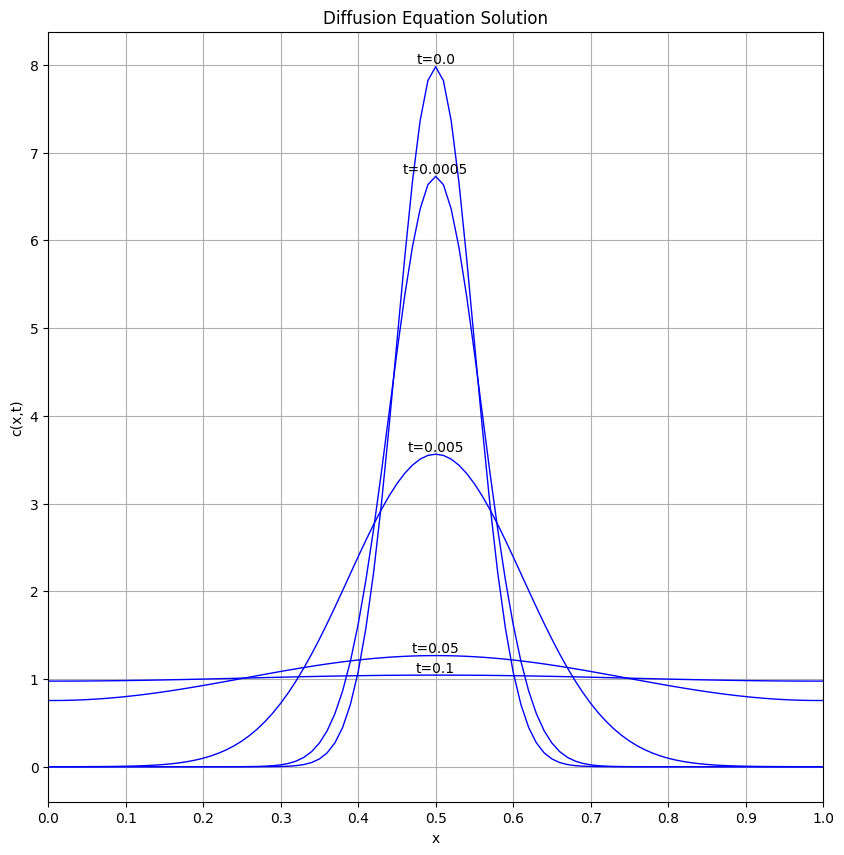

In [1]:
"""
扩散方程数值求解程序（一维显式差分格式）
采用有限差分法求解扩散方程 ∂c/∂t = D ∂²c/∂x² 
边界条件：零梯度边界（Neumann边界条件）
初始条件：标准高斯分布（μ=0.5，σ=0.05）
"""

# 导入数值计算和可视化库
import numpy as np
import matplotlib.pyplot as plt

# ============== 参数初始化 ==============
Nx = 100        # 空间离散点数
Nt = 2000       # 时间步总数
L = 1.0         # 空间域长度
T = 0.1         # 时间域长度
dx = L / Nx     # 空间步长
dt = T / Nt     # 时间步长

# 高斯分布参数
mu = 0.5        # 均值（分布中心位置）
sigma = 0.05    # 标准差（分布宽度）


def initial_condition(x):
    """
    定义初始条件函数（高斯分布）
    参数:
        x: 空间坐标
    返回值:
        标准正态分布的概率密度函数值
    """
    return np.exp(-((x - mu) ** 2) / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))


# 初始化浓度场数组（时间维度 × 空间维度）
c = np.zeros((Nt + 1, Nx + 1))

# ============== 初始条件设置 ==============
# 在空间网格点设置初始值（跳过边界点）
for n in range(Nx - 1):
    c[0, n + 1] = initial_condition((n + 1) * dx)

# 设置边界条件（零梯度边界）
c[0, 0] = c[0, 1]        # 左边界
c[0, Nx] = c[0, Nx - 1]  # 右边界

# ============== 显式差分格式计算 ==============
alpha = dt / dx**2  # 计算稳定性参数

# 时间迭代循环
for i in range(Nt):
    # 空间节点循环（跳过边界点）
    for j in range(1, Nx):
        # 使用显式差分公式更新浓度值
        c[i + 1, j] = (
            alpha * c[i, j - 1] + (1 - 2 * alpha) * c[i, j] + alpha * c[i, j + 1]
        )

    # 更新边界条件
    c[i + 1, 0] = c[i + 1, 1]        # 左边界保持零梯度
    c[i + 1, Nx] = c[i + 1, Nx - 1]  # 右边界保持零梯度

# ============== 结果可视化 ==============
x = np.linspace(0, L, Nx + 1)  # 生成空间坐标数组
plt.figure(figsize=(10, 10))   # 创建画布

# 绘制特定时刻的浓度分布曲线
for i in [0, 10, 100, 1000, 2000]:
    plt.plot(x, c[i, :], "b-", linewidth=1)  # 绘制当前时刻的曲线
    plt.text(
        0.5,
        c[i, 50],
        f"t={i * dt}",  # 在曲线中部添加时间标签
        ha="center",
        va="bottom",    # 文本对齐方式
        fontsize=10,
    )

# 设置图表属性
plt.title("Diffusion Equation Solution")  # 标题
plt.xlabel("x")                           # x轴标签
plt.ylabel("c(x,t)")                      # y轴标签
plt.xlim(0, L)                            # x轴范围
plt.xticks(np.arange(0, L + 0.1, 0.1))    # 设置x轴刻度
plt.grid()                                # 显示网格线
plt.show()                                # 显示图表

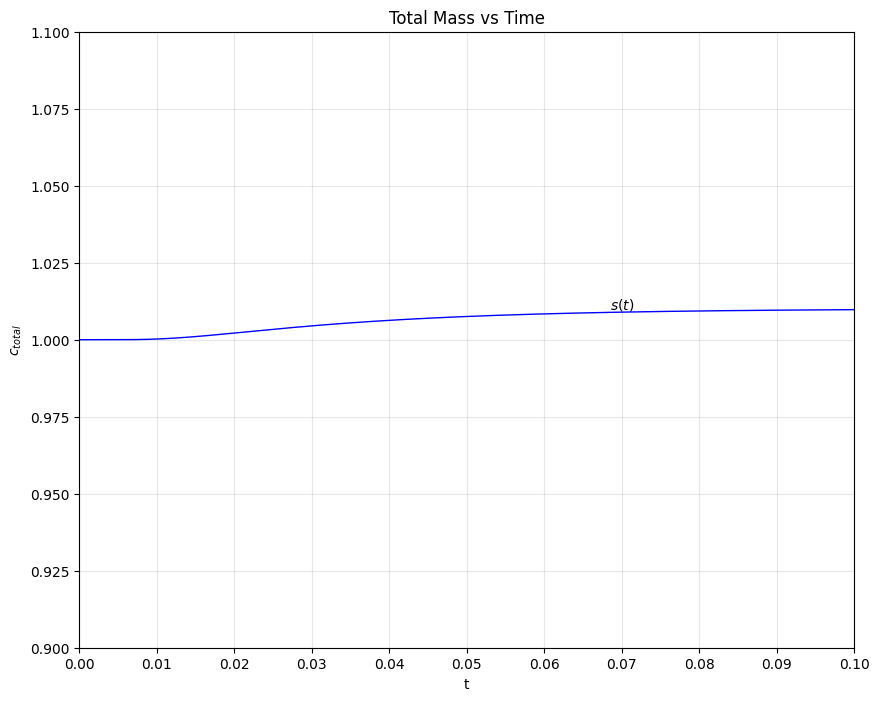

In [2]:
# ============== 总量计算模块 ==============
# 初始化总量数组（每个时间步对应的总量值）
s = np.zeros(Nt + 1)
# 生成时间坐标数组（从0到T均匀分布Nt+1个点）
t = np.linspace(0, T, Nt + 1)

# 使用复合辛普森法则进行数值积分
for i in range(Nt + 1):
    """
    复合辛普森积分公式实现：
    ∫c(x,t)dx ≈ (Δx/3)[c0 + 4c1 + 2c2 + 4c3 + ... + cn]
    代码实现等效形式：
    2*(总和 + 奇数项和) - 边界项，最后乘以dx/3
    """
    s[i] = (
        (
            2 * (np.sum(c[i, :]) + np.sum(c[i, :][1::2]))  # 计算全部节点和与奇数节点和
            - c[i, 0]
            - c[i, Nx]
        )
        * dx
        / 3
    )  # 修正边界项并应用辛普森系数

# ============== 总量变化可视化 ==============
plt.figure(figsize=(10, 8))
# 绘制总量随时间变化曲线
plt.plot(t, s, "b-", linewidth=1)
# 在t=0.07附近添加文本标注
plt.text(0.07, s[1400], "$s(t)$", ha="center", va="bottom", fontsize=10)  # 文本居中底部对齐

# 设置图表属性
plt.title("Total Mass vs Time")           # 设置标题
plt.xlabel("t")                           # x轴标签
plt.ylabel("$c_{total}$")                 # y轴标签（LaTeX格式）
plt.xlim(0, T)                            # x轴范围限制
plt.xticks(np.arange(0, T + 0.01, 0.01))  # 设置x轴刻度（步长0.01）
plt.ylim(0.9, 1.1)                        # y轴范围限制（显示守恒特性）
plt.grid(alpha=0.3)                       # 设置半透明网格线
plt.show()                                # 显示图表